In [2]:
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import time
import theano.tensor as tt

In [3]:
df = io.load("2018_HSNCT_overall")
df = (df
      .eval("powers_per_tuh = P / TUH")
      .eval("tens_per_tuh = TU / TUH")
      .eval("negs_per_tuh = I / TUH")
      .eval("points_per_tuh = Points / TUH")
     )

2019-06-08 19:55:41,533 - kedro.io.data_catalog - INFO - Loading data from `2018_HSNCT_overall` (ExcelLocalDataSet)...


In [ ]:
df.head()

In [ ]:
df[['PPB',"powers_per_tuh", "tens_per_tuh", "negs_per_tuh", "%"]].corr()

In [ ]:
sns.pairplot(df[['PPB',"powers_per_tuh", "tens_per_tuh", "negs_per_tuh", "%"]])

In [ ]:
import requests
from bs4 import BeautifulSoup
import re
from toolz.functoolz import pipe

In [ ]:
url = "https://www.naqt.com/stats/tournament/standings.jsp?tournament_id=9500"
page = requests.get(url)

In [ ]:
page

In [ ]:
soup = BeautifulSoup(page.content, 'html.parser')
print(soup.prettify())

In [ ]:
tb = soup.find('table', class_='data-freeze-2 unstriped')

In [ ]:
all_teams = [str(x) for x in tb.find_all("a")]

In [ ]:
pattern_number = "team_id=([0-9]+)"
pattern_team = ">(.+)<"
number_team = [(re.findall(pattern_number, line)[0], re.findall(pattern_team, line)[0]) for line in all_teams]

In [ ]:
i = 2
print(all_teams[i])
print(str(number_team[i]))

In [ ]:
# pd.read_html("https://www.naqt.com/stats/tournament/standings.jsp?tournament_id=9500")[1]

In [ ]:
result = pd.DataFrame()
for i, (number, team) in enumerate(number_team):
    try:
        print(i)
        tmp = pd.read_html("https://www.naqt.com/stats/tournament/team.jsp?team_id=" + number)[2]
        tmp["team"] = team
        result = pd.concat([result, tmp])
        time.sleep(1)
    except:
        print("{0} {1} {2}".format(i, number, team))

In [ ]:
result.to_csv("data/03_primary/all_games.csv", index=False)

# Analyze game data

In [4]:
# Process all games
all_games = io.load("2018_all_games")
rename_dict = {
    "P":"team_1_powers",
    "TU":"team_1_tens",
    "I":"team_1_negs",
    "B":"team_1_bonus_points",
    "PPB":"team_1_ppb",
    "P.1":"team_2_powers",
    "TU.1":"team_2_tens",
    "I.1":"team_2_negs",
    "B.1":"team_2_bonus_points",
    "PPB.1":"team_2_ppb",
    "team":"team_1",
    "Opponent":"team_2"
}
print(all_games.shape)
all_games = (all_games
             .rename(rename_dict, axis=1)
             .query("Score != 'Forfeit'")
             .eval("team_1_score = team_1_powers * 15 + team_1_tens * 10 - team_1_negs * 5 + team_1_bonus_points")
             .eval("team_2_score = team_2_powers * 15 + team_2_tens * 10 - team_2_negs * 5 + team_2_bonus_points")
             .eval("point_diff = team_1_score - team_2_score")
             .drop(["Result"], axis=1)
            )
all_games["point_diff_normalized"] = (all_games["point_diff"] - all_games["point_diff"].mean()) / all_games["point_diff"].std()

# Add a unique numeric index for each team
team_indices = (pd.DataFrame(list(set(all_games["team_1"].unique()) | set(all_games["team_2"].unique())))
                .reset_index()
                .rename({0:"team"}, axis=1)
                .set_index("team")
                .to_dict()["index"]
               )
all_games["team_1_index"] = all_games["team_1"].map(team_indices)
all_games["team_2_index"] = all_games["team_2"].map(team_indices)

assert all_games[all_games["team_1_index"].isna()].empty
assert all_games[all_games["team_2_index"].isna()].empty

# Find and remove duplicate games
all_games["teams"] = [tuple(sorted(x)) for x in zip(all_games["team_1"], all_games["team_2"])]
all_games = (all_games
             .drop_duplicates(["Round", "teams"])
             .drop(["teams"], axis=1)
            )

print(all_games.shape)
all_games.columns = all_games.columns.str.lower()

2019-06-08 19:55:41,703 - kedro.io.data_catalog - INFO - Loading data from `2018_all_games` (CSVLocalDataSet)...
(3726, 17)
(1936, 22)


In [5]:
all_games.head()

,unnamed: 0,round,score,team_1_powers,team_1_tens,team_1_negs,team_1_bonus_points,team_1_ppb,tuh,team_2,...,team_2_negs,team_2_bonus_points,team_2_ppb,team_1,team_1_score,team_2_score,point_diff,point_diff_normalized,team_1_index,team_2_index
0,0,1,600 – 45,7.0,11.0,3.0,400.0,22.22,23.0,Wayzata E,...,2.0,30.0,15.00,Beavercreek,600.0,45.0,555.0,2.850637,270,57
1,1,2,450 – 160,6.0,8.0,4.0,300.0,21.43,21.0,Providence A,...,0.0,90.0,15.00,Beavercreek,450.0,160.0,290.0,1.489522,270,218
2,2,3,585 – 105,9.0,8.0,0.0,370.0,21.76,22.0,Greenhill A,...,1.0,70.0,23.33,Beavercreek,585.0,105.0,480.0,2.465416,270,319
3,3,4,495 – 215,8.0,7.0,3.0,320.0,21.33,24.0,Allderdice A,...,1.0,130.0,18.57,Beavercreek,495.0,215.0,280.0,1.438159,270,238
4,4,5,450 – 290,3.0,11.0,3.0,310.0,22.14,23.0,Northview A,...,3.0,190.0,21.11,Beavercreek,450.0,290.0,160.0,0.821805,270,13


### Model

Model and code are based on [this article](http://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/).

Our goal is to come up with an underlying team strength parameter as well as uncertainty around that team strength parameter. Let $y_{gj}$ be the observed score for team $j$ in game $g$. We model the score using a Poisson distribution i.e. $y_{gj}|\theta_{gj} \sim Poisson(\theta_{gj})$. Note that there is one $\theta_{gj}$ for each team in each round. 

At the next level of the model, we model each $\theta$ as a log-linear function:
$$
\log \theta_{g1} = attack_1 - defense_2 \\
\log \theta_{g2} = attack_2 - defense_1
$$
i.e. we assume there is an attack and defense strength for each team. These parameters are modeled as a hierarchical model where, for each team $t$,
$$
attack_t \sim N(\mu_{attack},\tau_{attack}) \\
defense_t \sim N(\mu_{defense},\tau_{defense})
$$
And in turn we have hyperpriors where $\mu_{attack}, \mu_{defense} \sim N(.,.)$ and $\tau_{attack}, \tau_{defense} \sim Gamma(.,.)$

To ensure identifiability, we make the attack and defense parameters sum to 0:
$$
\sum_{t \in Teams} attack_t = 0 \\
\sum_{t \in Teams} defense_t = 0
$$


In [6]:
num_teams = len(set(all_games["team_1"].unique()) | set(all_games["team_2"].unique()))
team_1 = all_games["team_1_index"].values
team_2 = all_games["team_2_index"].values

In [101]:
# %debug
with pm.Model() as model:
    
    #hyperpriors
    tau_attack = pm.Gamma('tau_attack', alpha=20, beta=20)
    tau_defense = pm.Gamma('tau_defense', alpha=20, beta=20)
#     intercept = pm.HalfNormal('intercept', sd=1)

    # team-specific model parameters
    atts_star = pm.Normal("atts_star", mu=0, sd=tau_attack, shape=num_teams)
    defs_star = pm.Normal("defs_star", mu=0, sd=tau_defense, shape=num_teams)
    
    atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    team_1_theta = tt.exp(atts[team_1] + defs[team_2])
    team_2_theta = tt.exp(atts[team_2] + defs[team_1])
    
    # likelihood of observed data
    team_1_points = pm.Poisson('team_1_points', mu=team_1_theta, observed=all_games["team_1_score"])
#     team_2_points = pm.Poisson('team_2_points', mu=team_2_theta, observed=all_games["team_2_score"])

    prior = pm.sample_prior_predictive(samples=1000)
    trace = pm.sample()
    posterior_predictive = pm.sample_posterior_predictive(trace)

2019-06-09 11:31:04,132 - pymc3 - INFO - Auto-assigning NUTS sampler...
2019-06-09 11:31:04,133 - pymc3 - INFO - Initializing NUTS using jitter+adapt_diag...


KeyboardInterrupt: 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c3c580390>,
      dtype=object)

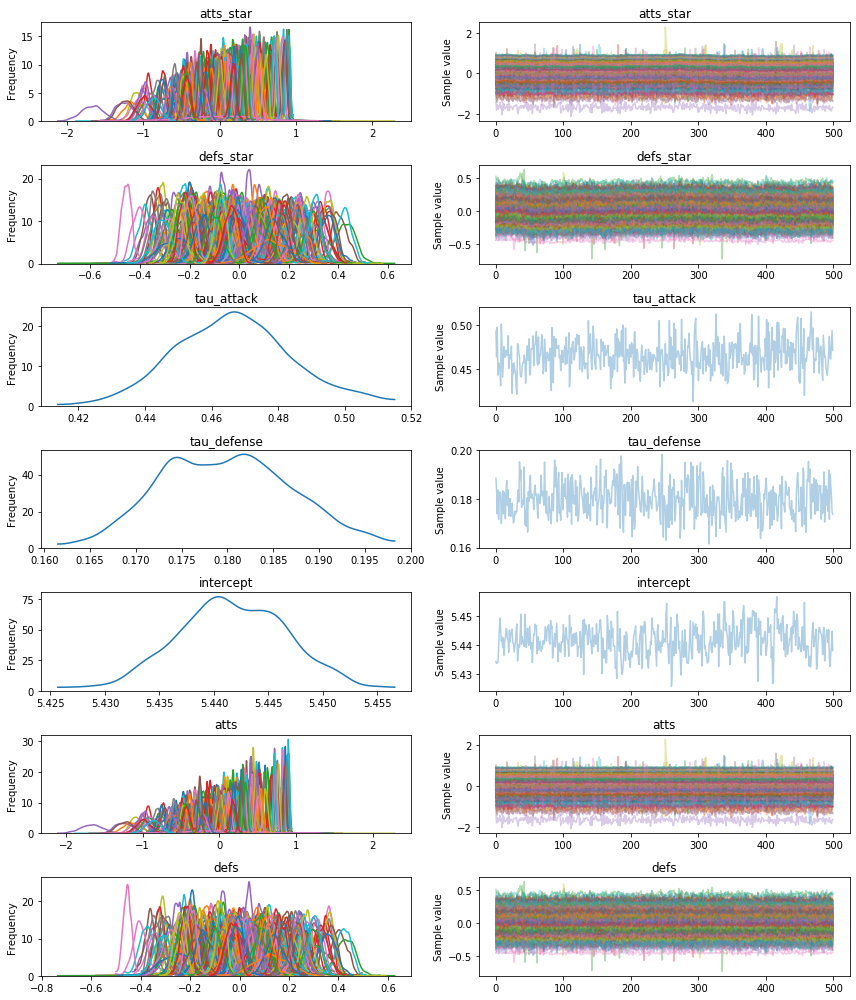

In [90]:
pm.traceplot(trace)

In [99]:
team_ranks = (trace.get_values("atts")).mean(axis=0).argsort()[::-1]
team_indices_reverse = {val:key for key, val in team_indices.items()}
[team_indices_reverse[idx] for idx in team_ranks]

['Thomas Jefferson Science &amp; Tech A',
 'James E. Taylor',
 'Richard Montgomery A',
 'Hunter A',
 'Arcadia A',
 'Beavercreek',
 'High Tech A',
 'University Lab',
 'Rockford Auburn',
 'Wayzata A',
 'Ithaca',
 'IMSA',
 'LASA A',
 'Ladue',
 'Northview A',
 'Adlai E. Stevenson A',
 'Chattahoochee A',
 'Montgomery Blair A',
 'Miami Valley',
 'Canyon Crest A',
 'Stanford Online A',
 'Strake Jesuit A',
 'Westminster A',
 'Detroit Catholic Central A',
 'Boston Latin',
 'Georgetown Day',
 'Wilmington Charter',
 "St. John's",
 'Lusher',
 'Lexington A',
 'Carnegie Vanguard',
 'Richard Montgomery B',
 'Hempfield',
 'Millburn A',
 'Allderdice A',
 'Early College at Guilford',
 'Chattahoochee B',
 'Thomas Jefferson Science &amp; Tech B',
 'Mission San Jose',
 'Saratoga A',
 'Vestavia Hills',
 'Montgomery Blair B',
 'Hoover',
 'Hunter B',
 'Parish Episcopal',
 'Centennial A',
 'Leland',
 'Eastside A',
 'Glasgow',
 'Del Norte',
 'State College A',
 'Barrington',
 'Solon A',
 'Westview A',
 'Plano W

In [ ]:
data = az.from_pymc3(
        trace=trace,
        prior=prior,
        posterior_predictive=posterior_predictive,
    )

In [ ]:
model.check_test_point()

In [ ]:
prior.keys()

In [ ]:
print(prior["team_1_points"].mean(), prior["team_1_points"].max())
# print(prior["team_2_points"].mean(), prior["team_2_points"].max())

In [ ]:
sns.distplot(prior["team_1_points"].flatten())

In [87]:
# %debug


with pm.Model() as model:

    #hyperpriors
    sd_team_strength = pm.Gamma("sd_team_strength", alpha=1, beta=1)
    sd_likelihood = pm.Gamma("sd_likelihood", alpha=1, beta=1)

    # team-specific model parameters
    team_strength = pm.Normal("team_strength", mu=0, sd=sd_team_strength, shape=num_teams)
    strengths = pm.Deterministic('strengths', team_strength - tt.mean(team_strength))

    # likelihood of observed data
    mu = strengths[team_1] - strengths[team_2]
    point_diff = pm.Normal('point_diff', mu=mu, sd=sd_likelihood, observed=all_games["point_diff"])
    
    prior = pm.sample_prior_predictive(samples=1000)
    trace = pm.sample()
    posterior_predictive = pm.sample_posterior_predictive(trace)

2019-06-09 11:11:08,513 - pymc3 - INFO - Auto-assigning NUTS sampler...
2019-06-09 11:11:08,514 - pymc3 - INFO - Initializing NUTS using jitter+adapt_diag...
2019-06-09 11:11:10,291 - pymc3 - INFO - Multiprocess sampling (2 chains in 2 jobs)
2019-06-09 11:11:10,294 - pymc3 - INFO - NUTS: [team_strength, sd_likelihood, sd_team_strength]


Sampling 2 chains: 100%|██████████| 2000/2000 [02:26<00:00,  4.46draws/s]
/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


2019-06-09 11:13:37,881 - pymc3 - WARNING - The acceptance probability does not match the target. It is 0.994734619032761, but should be close to 0.8. Try to increase the number of tuning steps.
2019-06-09 11:13:37,884 - pymc3 - WARNING - The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
2019-06-09 11:13:37,885 - pymc3 - WARNING - The acceptance probability does not match the target. It is 0.9958292740303984, but should be close to 0.8. Try to increase the number of tuning steps.
2019-06-09 11:13:37,887 - pymc3 - INFO - The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
2019-06-09 11:13:37,889 - pymc3 - ERROR - The estimated number of effective samples is smaller than 200 for some parameters.


100%|██████████| 1000/1000 [00:01<00:00, 980.56it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c40aa0588>,
      dtype=object)

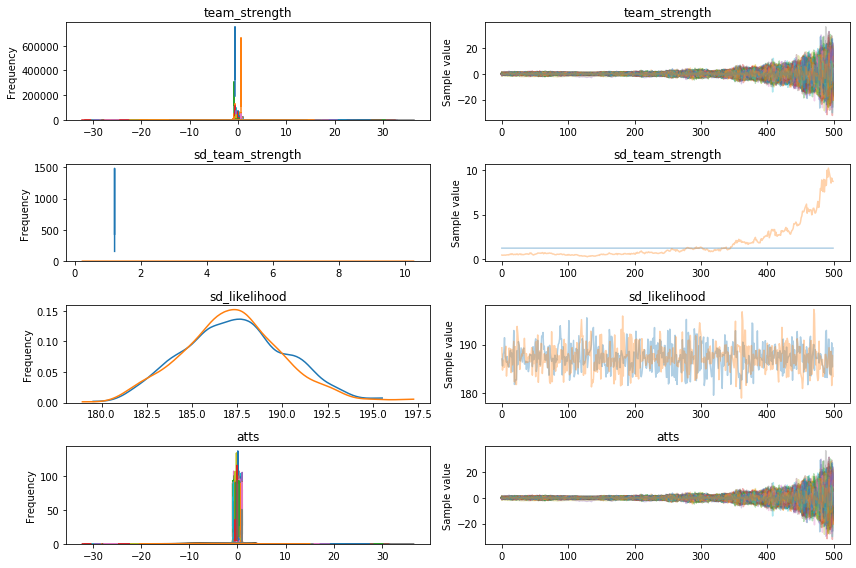

In [88]:
pm.traceplot(trace)

In [82]:
# from simulation_based_calibration import SBC, plot_sbc
# sbc = SBC(my_model, "y",
#         num_simulations=10)

# sbc.run_simulations()

In [83]:
prior.keys()

dict_keys(['point_diff', 'sd_likelihood', 'sd_team_strength', 'sd_likelihood_log__', 'sd_team_strength_log__', 'team_strength'])

In [84]:
prior["point_diff"].min(), prior["point_diff"].mean(), prior["point_diff"].max()

(-27.349105235290473, 0.005718887357961979, 34.073825354866536)

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


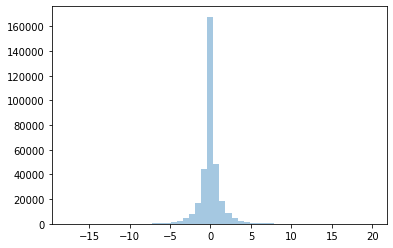

In [85]:
sns.distplot(prior["team_strength"].flatten(), kde=False)